In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords, brown
from nltk import word_tokenize
from nltk.util import ngrams
import math
stop_words = set(stopwords.words('english'))
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
%matplotlib inline

['embeddings', 'train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
#importing the data
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (56370, 2)


In [3]:
#Number of words in the text
train_df["words#"] = train_df["question_text"].apply(lambda x: len(str(x).split()))
test_df["words#"] = test_df["question_text"].apply(lambda x: len(str(x).split()))

#Number of unique words in the text
train_df["unique_words#"] = train_df["question_text"].apply(lambda x: len(set(str(x).split())))
test_df["unique_words#"] = test_df["question_text"].apply(lambda x: len(str(x).split()))

In [4]:
#nlp/machine learning libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.metrics import f1_score,classification_report,roc_curve,precision_recall_curve,auc,average_precision_score
from sklearn.feature_selection import chi2, SelectKBest
import re
import pandas, xgboost, numpy, textblob, string
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [5]:
X = train_df[['question_text', 'words#','unique_words#']]
Y = train_df['target']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [6]:
# using function transformer to get the text data
text = FunctionTransformer(lambda x: x['question_text'], validate=False)
numeric = FunctionTransformer(lambda x: x[['words#','unique_words#']], validate=False)
text_numeric_features = FeatureUnion(
                            transformer_list = [
                            ('text_feature', Pipeline([
                                ('text', text),
                                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))),
                            ])),
                            ('numeric_features', Pipeline([
                                ('numeric', numeric),
                                ('scale', StandardScaler()),
                            ]))
                            ])

logistic_regression_advancedfeatures = Pipeline([
    ('join_features', text_numeric_features),
    ('classifier', LogisticRegression(solver='sag')),
])


In [7]:
#fitting the pipeline to the train data
logistic_regression_advancedfeatures.fit(X_train, y_train )

Pipeline(memory=None,
     steps=[('join_features', FeatureUnion(n_jobs=None,
       transformer_list=[('text_feature', Pipeline(memory=None,
     steps=[('text', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lambda> at 0x7f2d7af69d90>, inv_kw_args=None,
          inverse_func=None, kw... penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False))])

In [8]:
logistic_regression_advancedfeatures_preds = logistic_regression_advancedfeatures.predict(X_test)
print(classification_report(y_test, logistic_regression_advancedfeatures_preds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97    245155
           1       0.60      0.54      0.57     16070

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.78      0.76      0.77    261225
weighted avg       0.95      0.95      0.95    261225



In [9]:
logistic_regression_advancedfeatures_preds_prob = logistic_regression_advancedfeatures.predict_proba(X_test)[:,1]

#### Choosing Optimal threshold with better F1 score


In [10]:
f1_list = []
for threshold in np.arange(0.1, 0.8, 0.01):
    threshold = np.round(threshold, 2)
    f1_list.append((f1_score(y_test, (logistic_regression_advancedfeatures_preds_prob>threshold).astype(int)),threshold))
    print("F1 score at threshold {0} is {1}".format(threshold, f1_score(y_test, (logistic_regression_advancedfeatures_preds_prob>threshold).astype(int))))

F1 score at threshold 0.1 is 0.49806150087630785
F1 score at threshold 0.11 is 0.510390231343558
F1 score at threshold 0.12 is 0.5208091936556177
F1 score at threshold 0.13 is 0.5301808502309558
F1 score at threshold 0.14 is 0.5387369267900242
F1 score at threshold 0.15 is 0.5452110121991428
F1 score at threshold 0.16 is 0.5506855093862053
F1 score at threshold 0.17 is 0.5559270844569086
F1 score at threshold 0.18 is 0.5613563800506441
F1 score at threshold 0.19 is 0.5663506044128881
F1 score at threshold 0.2 is 0.5696506600169294
F1 score at threshold 0.21 is 0.5726855839288624
F1 score at threshold 0.22 is 0.5750497488865727
F1 score at threshold 0.23 is 0.5776258455908906
F1 score at threshold 0.24 is 0.5803468773697987
F1 score at threshold 0.25 is 0.5826158159847149
F1 score at threshold 0.26 is 0.5851200524048272
F1 score at threshold 0.27 is 0.5859365022604787
F1 score at threshold 0.28 is 0.5873085792760344
F1 score at threshold 0.29 is 0.5884298388366843
F1 score at threshold 

In [11]:
def sort_tuple(tup):
    return tup[0]

best_threshold = sorted(f1_list,key=sort_tuple, reverse=True)[0][1]

In [12]:
##creating a submission file with the optimal threshold with the baseline model
def submission(df, predictions, file_name, threshold=0.20):
    print('Optimal threshold with better F1 score is: ', threshold)
    results = (predictions > threshold).astype(int)
    df['prediction'] = results
    file = (file_name + '.csv')
    df.to_csv(file, index=False)

In [13]:
#predicting the classes on test data
logistic_regression_advancedfeatures_preds_prob = logistic_regression_advancedfeatures.predict_proba(test_df)[:,1]

In [14]:
print('Saving the results in the submission file')
sub_df = pd.read_csv('../input/sample_submission.csv')
submission(sub_df, logistic_regression_advancedfeatures_preds_prob, 'submission', threshold=best_threshold)

Saving the results in the submission file
Optimal threshold with better F1 score is:  0.32


In [15]:
print("At threshold {0} we are getting better F1 score and we will be choosing this threshold for our submission.".format(best_threshold))

At threshold 0.32 we are getting better F1 score and we will be choosing this threshold for our submission.


### Precision Recall Curve

In [16]:
lr_advancedfeatures_preds_prob = logistic_regression_advancedfeatures.predict_proba(X_test)[:,1]

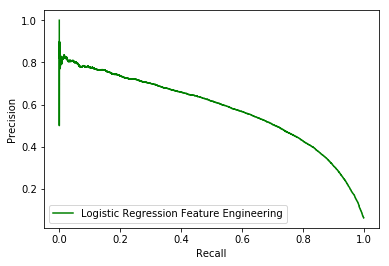

In [17]:
classfier_pred_list = [lr_advancedfeatures_preds_prob]
classifiers_list = ['Logistic Regression Feature Engineering']
count=0
for classifier,col in zip(classfier_pred_list,'g'):
    p,r,_ = precision_recall_curve(y_test,classifier)   
    plt.plot(r,p,c=col,label=classifiers_list[count])
    count += 1
plt.legend(loc='lower left')   
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()